# TP Séries temporelles

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import datetime
import numpy as np
from scipy import signal
from math import pi
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from cmath import exp

# Données "syndromes grippaux"

1. Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/suivi-epidemiologique-temps-reel/ias-incidence-des-syndromes-grippaux pour plus
d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler
seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la
fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données,
les cas de nullité correspondent à des données manquantes. Combiende données manquantes
comporte-t-elle ? Pour les traitements des questions suivantes, éliminez les données manquantes par
imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non-observées à partir
des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
# import des données
data = pd.read_csv("OpenhealthS-Grippal.csv", delimiter=";", decimal=",", na_values=0)
# affichage des 5 premières lignes
data.head(5)

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


In [3]:
# affichage des 5 dernières lignes
data.tail(5)

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
1747,2014-04-13,77.9,1.8,NaN
1748,2014-04-14,2.7,1.7,NaN
1749,2014-04-15,1.0,1.6,NaN
1750,2014-04-16,1.6,1.6,NaN
1751,2014-04-17,0.4,1.6,NaN


On observe que les données de l'échantillon sont de fréquence quotidienne. Elles commencent le 1er juillet 2009 et se terminent le 17 avril 2014, pour un total de 1752 observations. 

In [4]:
# comptage des valeurs manquantes
missing_values = data['IAS_brut'].isnull().sum()
print("Il y a " + str(missing_values) + " données manquantes dans la série IAS_brut.")

Il y a 8 données manquantes dans la série IAS_brut.


In [5]:
# correction par moyennisation des valeurs voisines
data.IAS_brut = data.IAS_brut.fillna((data.IAS_brut.shift() + data.IAS_brut.shift(-1))/2)

2. Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous
observez.

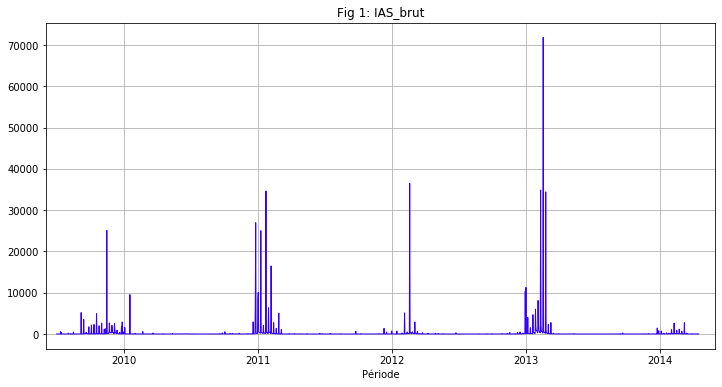

In [6]:
# conversion pour obtenir des dates lisibles par matplotlib
data['PERIODE'] = pd.to_datetime(data['PERIODE'])
# traçage du graphique
fig_1 = plt.figure(figsize=(12,6))
plt.plot(data['PERIODE'], data['IAS_brut'], linewidth=1, c=(0.2, 0, 1));
plt.title('Fig 1: IAS_brut')
plt.xlabel('Période')
plt.xlim([datetime.date(2009, 6, 1), datetime.date(2014, 6, 1)])
plt.grid(True)
plt.show()

On observe la présence d'une saisonalité marquée dans les données. La valeur de IAS_brut semble connaître un pic chaque année, généralement lors des premiers mois (exception: pour 2010, le pic s'est en réalité produit sur les derniers mois de l'année précédente). Le pic est extrêmement fort: alors que la série fluctue autour de valeurs proches de 0 sur le reste de l'année, elle atteint des valeurs de plusieurs dizaines de milliers lors du pic. On remarque aussi que la taille du pic varie selon les années: très faible en 2014 avec un valeur de 2000 environ, moyen en 2010, 2011 et 2012, extrême en 2013 avec des valeurs dépassant 70000.

3. Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme
a sur la trajectoire représentée à la question précédente ?

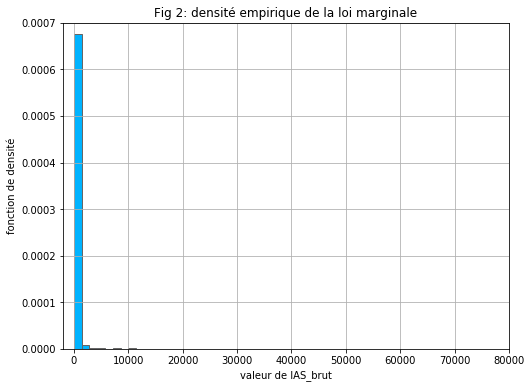

In [7]:
# traçage de l'histogramme de la loi marginale
fig2 = plt.figure(figsize=(8,6))
plt.hist(data['IAS_brut'], bins = 50, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('valeur de IAS_brut')
plt.ylabel('fonction de densité')
plt.title('Fig 2: densité empirique de la loi marginale')
plt.ylim(0, 0.0007) 
plt.xlim(-2000,80000)
plt.grid(True)
plt.show()

On observe une distribution avec une asymétrie positive extrêmement élevée. La distribution compte une immense majorité de petites valeurs (entre 0 et 1000), quelques valeurs entre 1000 et 10000, puis une nombre très faible de valeurs extrêmes supérieures à 10000. Cette distribution implique que la trajectoire de la question précédente est caractérisée par une immense majorité de valeurs faibles, avant de connaître parfois des épisodes de valeurs extrêmes de courte durée. Autrement dit, la trajectoire de la question précédente est caractérisée par la présence d'hétéroscédasticité.

4. Reprenez les questions précédentes après tranformations des observations par le logarithme naturel.
Commentez

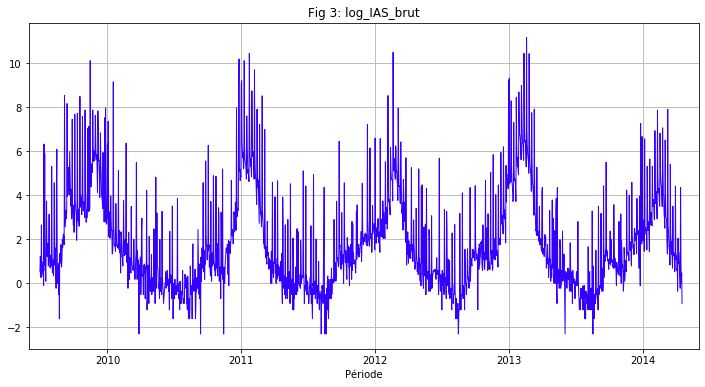

In [8]:
# transformation des données en log
data['log_IAS_brut'] = np.log(data['IAS_brut'])
# traçage du graphique de la série temporelle modifiée
fig_3 = plt.figure(figsize=(12,6))
plt.plot(data['PERIODE'], data['log_IAS_brut'], linewidth=1, c=(0.2, 0, 1));
plt.title('Fig 3: log_IAS_brut')
plt.xlabel('Période')
plt.xlim([datetime.date(2009, 6, 1), datetime.date(2014, 6, 1)])
plt.grid(True)
plt.show()

On note que les données se sont considérablement ressérrées autour de la moyenne, la dispersion a été largement réduite par le passage en logarithme. La saisonalité reste toujours présente.

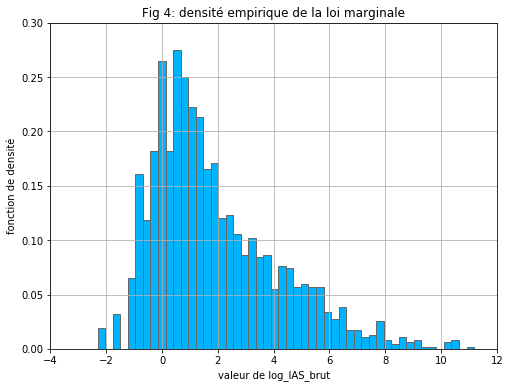

In [9]:
# traçage de l'histogramme de la loi marginale
fig4 = plt.figure(figsize=(8,6))
plt.hist(data['log_IAS_brut'], bins = 50, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.xlabel('valeur de log_IAS_brut')
plt.ylabel('fonction de densité')
plt.title('Fig 4: densité empirique de la loi marginale')
plt.ylim(0, 0.30) 
plt.xlim(-4,12)
plt.grid(True)
plt.show()

La distribution apparaît comme étant toujours positivement asymétrique, mais de façon moins extrême. Le passage en log a permis également de réduire la dispersion autour de la moyenne, la quasi-totalité des valeurs étant maintenant comprises entre -2 et 10.

5. En utilisant signal.perodogram() (du package signal importé depuis scipy), tracez le périodogramme
des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait
que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans
[-1/2, 1/2] plutôt que [-$\pi$, $\pi$].

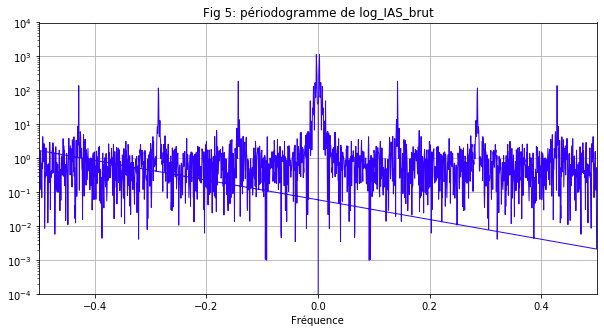

In [10]:
# estimation du périodogramme
f, Pxx = signal.periodogram(data['log_IAS_brut'], return_onesided = False)
# traçage du périodogramme
fig5 = plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, linewidth=1, c=(0.2, 0, 1))
plt.title('Fig 5: périodogramme de log_IAS_brut')
plt.xlabel('Fréquence')
plt.grid(True)
plt.xlim([-0.5, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

On observe un large pic autour des basses fréquences (entre 0 et 0.02, en valeur absolue), impliquant que ces dernières dominent le processus sous-jacent aux données. Cela explique un comportement exhibant des fluctuation cycliques lentes (à l'échelle de l'année), comme observé sur la Figure 4. On observe trois autres pics de fréquence, aux valeurs de 0.15, 0.30 et 0.45 (sur un spectre normalisé). Cela implique que les processus, en plus des basses fréquences, possède aussi quelques composantes significatives de moyennes et hautes fréquences, impliquant un certain nombre de cycles plus courts dans son comportement. Sur la Figure 3, on peut observer que ces cycles courts sont les plus significatifs en début d'année, ce qui indique une période de fluctuations rapides de la variable log_IAS_brut sur cette période.

6. Pour supprimer une tendance périodique de période $T$ dans un signal $(x_t)_{t \in Z}$ il suffit d’appliquer
le filtre $\Delta_T$ défini par:

$[ \Delta_T x_t ] = x_t - x_{t-T}$

Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme
cette méthode a fait disparaître ?

On remarque que la série log_IAS_brut est complète (les 365 jours de l'année y sont présents). On peut donc enlever facilement la tendance en soustrayant à chaque valeur la valeur de la série qui se trouve 365 entrées plus tôt. D'autre part, on va nécessairement perdre dans le processus un an de données, puisque la première année ne peut être différenciée.

In [11]:
# on génère les séries des périodes t et t-365, puis soustrait pour obtenir la différence première
diff_log_IAS_brut = data['log_IAS_brut'].iloc[365:].to_numpy() - data['log_IAS_brut'].iloc[:-365].to_numpy()

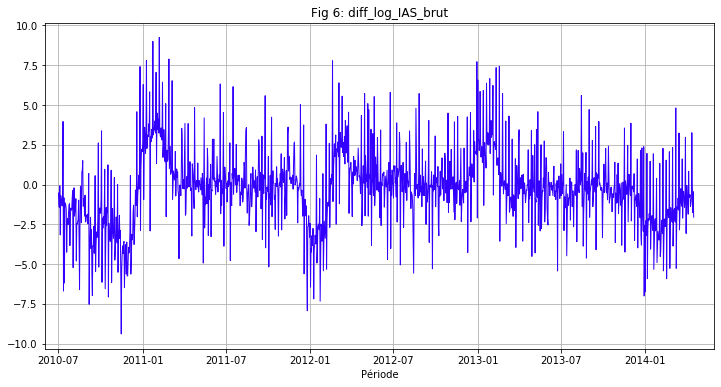

In [12]:
# traçage du graphique de la série temporelle modifiée
fig_6 = plt.figure(figsize=(12,6))
plt.plot(data['PERIODE'].iloc[365:], diff_log_IAS_brut, linewidth=1, c=(0.2, 0, 1));
plt.title('Fig 6: diff_log_IAS_brut')
plt.xlabel('Période')
plt.xlim([datetime.date(2010, 6, 1), datetime.date(2014, 6, 1)])
plt.grid(True)
plt.show()

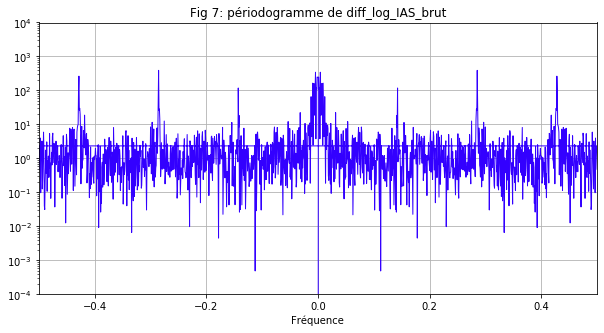

In [13]:
# estimation du périodogramme
f, Pxx = signal.periodogram(diff_log_IAS_brut, return_onesided = False)
# traçage du périodogramme
fig7 = plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx, linewidth=1, c=(0.2, 0, 1))
plt.title('Fig 7: périodogramme de diff_log_IAS_brut')
plt.xlabel('Fréquence')
plt.grid(True)
plt.xlim([-0.5, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

En prenant la différence première avec les données une années auparavant, on s'attend à faire disparaître les cycles annuels. Dans notre set de données, ils correspondent à la plus basse fréquence, c'est-à-dire celle proche de zéro. On observe en effet quand dans notre périodogramme, le pic qui apparaissait exactement à 0 a disparu (comparer avec la Figure 5).

7. On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va
prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant
sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance
périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez
les variables explicatives pour la période d’apprentissage : pour chaque $k = 1, 2, \cdots,$ n_harm, ajoutez
deux variables explicatives, $x_{i,2k-1} = cos (t_i . k . \frac{2 \pi}{T})$ et $x_{i,2k} = sin (t_i . k . \frac{2 \pi}{T})$, où $t_i$ est le moment
de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. Estimez la tendance
périodique en régressant les données d’apprentissage sur ces variables explicatives.

    Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013
au 17 avril 2014.
Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez
utilisez les couleurs différentes pour pour les partie apprentissage et prédiction). Puis, donnez le
risque quadratique de la prédiction et tracez les résidus pour la période prédite.
Essayez les valeur de n_harm pour voir comment varie le risque quadratique de la prédiction.

In [14]:
# définition des paramètres
n_harm = 5
T = 365

In [15]:
# on commence par rajouter une colonne de temps t_i sur le dataframe initial
data_time = data.copy()
data_time['t_i'] = data_time.index + 1
# on rajoute ensuite les séries de cosinus et sinus sur lesquels on regressera notre pseudo série de Fourier
for k in range(1, n_harm+1):
    data_time['cos_' + str(k)] = np.cos(data_time['t_i'] * k * (2*pi/T))
    data_time['sin_' + str(k)] = np.sin(data_time['t_i'] * k * (2*pi/T))

In [16]:
data_time.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles,log_IAS_brut,t_i,cos_1,sin_1,cos_2,sin_2,cos_3,sin_3,cos_4,sin_4,cos_5,sin_5
0,2009-07-01,1.7,2.2,2.3,0.530628,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965
1,2009-07-02,3.4,2.1,2.3,1.223775,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293
2,2009-07-03,2.1,2.1,2.3,0.741937,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353
3,2009-07-04,1.3,2.0,2.3,0.262364,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523
4,2009-07-05,14.2,2.0,2.3,2.653242,5,0.996298,0.085965,0.985220,0.171293,0.966848,0.255353,0.941317,0.337523,0.908818,0.417194


In [17]:
# on crée ensuite un dataframe d'apprentissage ne comprenant que les périodes et la variable d'intérêt
data_app = data_time.drop(['IAS_lisse', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1).loc[data['PERIODE'] < '2013-04-01']
# on crée enfin un dataframe de prédiction sur les périodes restantes
data_pred = data_time.drop(['IAS_lisse', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1).loc[data['PERIODE'] >= '2013-04-01']

In [18]:
data_app.head()

,PERIODE,IAS_brut,cos_1,sin_1,cos_2,sin_2,cos_3,sin_3,cos_4,sin_4,cos_5,sin_5
0,2009-07-01,1.7,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965
1,2009-07-02,3.4,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293
2,2009-07-03,2.1,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353
3,2009-07-04,1.3,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523
4,2009-07-05,14.2,0.996298,0.085965,0.985220,0.171293,0.966848,0.255353,0.941317,0.337523,0.908818,0.417194


In [19]:
# on passe les données en numpy pour pouvoir faire de la régression sous scikit learn
Y_app = data_app['IAS_brut'].to_numpy()
X_app = data_app.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
# estimation du modèle linéaire
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X_app,Y_app);

In [20]:
# on crée maintenant les échantillons de prédiction
Y_pred = data_pred['IAS_brut'].to_numpy()
X_pred = data_pred.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
# on réalise la prédiction
pred = reg.predict(X_pred)
data_pred['pred'] = pred

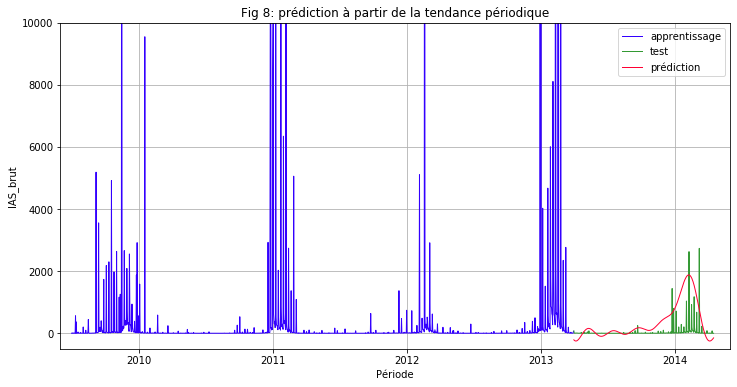

In [21]:
# on réalise le graphique
fig_8 = plt.figure(figsize=(12,6))
plt.plot(data_app['PERIODE'], data_app['IAS_brut'], linewidth=1, c=(0.2, 0, 1), label="apprentissage");
plt.plot(data_pred['PERIODE'], data_pred['IAS_brut'], linewidth=1, c=(0.2, .6, 0.2), label="test");
plt.plot(data_pred['PERIODE'], data_pred['pred'], linewidth=1, c=(1, 0, 0.2), label="prédiction");
plt.legend()
plt.title('Fig 8: prédiction à partir de la tendance périodique')
plt.xlabel('Période')
plt.ylabel('IAS_brut')
plt.xlim([datetime.date(2009, 6, 1), datetime.date(2014, 6, 1)])
plt.ylim([-500, 10000])
plt.grid(True)
plt.show()

In [22]:
# calcul du risque quadratique de la prédiction (normalisé par le nombre d'observations)
resids = Y_pred - pred
risk = np.sum(resids ** 2) / len(Y_pred)
print("le risque quadratique de la prédiction est de " + str(round(risk,2)) + ".")

le risque quadratique de la prédiction est de 384978.2.


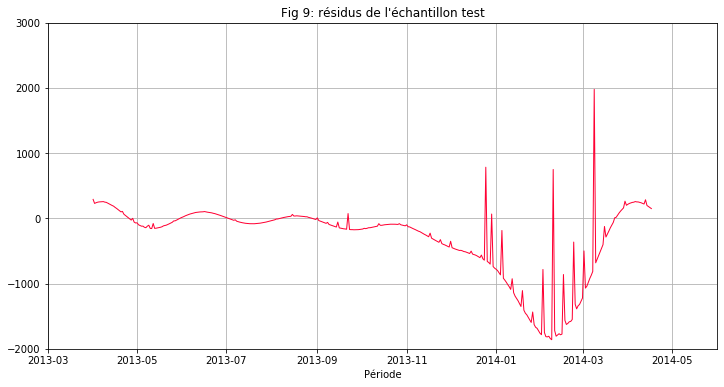

In [23]:
# traçage des résidus
fig_9 = plt.figure(figsize=(12,6))
plt.plot(data_pred['PERIODE'], resids, linewidth=1, c=(1, 0, 0.2));
plt.title("Fig 9: résidus de l'échantillon test")
plt.xlabel('Période')
plt.xlim([datetime.date(2013, 3, 1), datetime.date(2014, 6, 1)])
plt.ylim([-2000, 3000])
plt.grid(True)
plt.show()

In [24]:
# on essaye maintenant diverses valeurs de n_harm pour améliorer le risque quadratique de prédiction

# nombre maximum d'harmoniques à tester
max_n_harm = 100
    
# on boucle maintenant sur le nombre maximum d'harmoniques, estimant le modèle et le risque prédictif
risks = np.zeros([max_n_harm])
for n_harm in range(1, max_n_harm + 1):
    data_time = data.copy()
    data_time['t_i'] = data_time.index + 1
    for k in range(1, n_harm + 1):
        data_time['cos_' + str(k)] = np.cos(data_time['t_i'] * k * (2*pi/T))
        data_time['sin_' + str(k)] = np.sin(data_time['t_i'] * k * (2*pi/T))
    data_app = data_time.drop(['IAS_lisse', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1).loc[data['PERIODE'] < '2013-04-01']
    data_pred = data_time.drop(['IAS_lisse', 'Incidence_Sentinelles', 'log_IAS_brut', 't_i'], axis=1).loc[data['PERIODE'] >= '2013-04-01']
    Y_app = data_app['IAS_brut'].to_numpy()
    X_app = data_app.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_app,Y_app);
    Y_pred = data_pred['IAS_brut'].to_numpy()
    X_pred = data_pred.drop(['PERIODE', 'IAS_brut'], axis=1).to_numpy()
    pred = reg.predict(X_pred)
    resids = Y_pred - pred
    risk = np.sum(resids ** 2) / len(Y_pred)
    risks[n_harm - 1] = risk

min_risk = min(risks)
min_harm = np.argmin(risks) + 1  

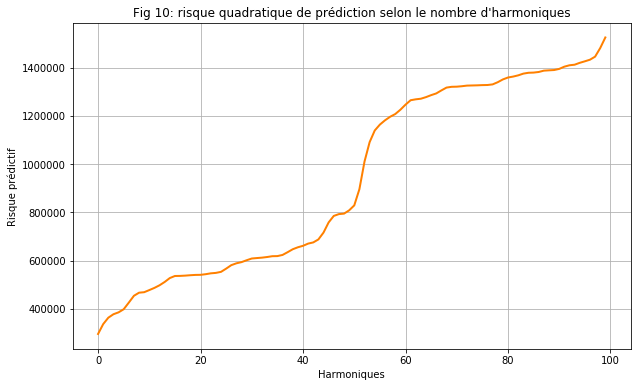

Le risque quadratique de prédiction minimum est de 295268.0. Il est atteint pour un modèle avec 1 harmoniques.


In [25]:
# traçage des valeurs de risque
fig_10 = plt.figure(figsize=(10,6))
plt.plot(risks, linewidth=2, c=(1, 0.5, 0));
plt.title("Fig 10: risque quadratique de prédiction selon le nombre d'harmoniques")
plt.xlabel('Harmoniques')
plt.ylabel('Risque prédictif')
plt.grid(True)
plt.show()

# impression du nombre d'harmoniques minimisant le risque
print("Le risque quadratique de prédiction minimum est de " + str(round(min_risk)) + ". Il est atteint pour un modèle avec " + str(min_harm) + " harmoniques.")

Commentaires:

Notre modèle de prédiction estime une pseudo suite de Fourier, prenant les 5 premières premières harmoniques (de basse, voire moyenne fréquence). Ces composantes sont aisément reconnaissables sur la Figure 8, avec d'une côté une sinusoide de cycle long visible sur la période allant de novembre 2013 à avril 2014, et des cycles un peu plus courts sur la période précédente.

Ce modèle fournit des résidus plutot satisfaisants sur la première période. Comme on peut le voir sur la Figure 9, ils sont alors centrés en 0, mais souffrent d'autocorrelation. Sur la seconde période en revanche, les performances du modèle sont médiocre. Le modèle essaie en effet de capturer les pics de haute fréquence de la série par ses composantes de basse fréquence. Lors des pics, la prédiction est ainsi plutôt bonne et les résidus sont centrés en 0. Hors des pics toutefois, la composante basse fréquence amène à systématiquement surestimer la prédiction, ce qui résulte en une série de larges résidus négatifs, comme on peut l'observer sur la Figure 9. Globalement, les performances sont peu satisfaisantes.

On peut alors essayer de jouer sur le paramètre n_harm pour améliorer les résutats. En testant un nombre d'harmoniques de 1 à 100, on observe que le meilleur résultat sur l'échantillon test est obtenu pour une seule harmonique. Cela implique que la meilleure représentation de la série est obtenue en prenant uniquement en compte la composante de plus basse fréquence, c'est-à-dire les cycles longs. En augmentant le nombre d'harmoniques pour essayer de capturer les fréquences plus élevées, on capture essentiellement du bruit. Cela illustre le compromis biais/variance: un modèle avec d'avantage d'harmoniques réduit le biais, mais l'augmentation de la variance amène finalement une détérioration de sa performance.


# Données "trafic internet"

8. Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet
et la première variable et le moment de sa transmission; consultez http://ita.ee.lbl.gov/html/
contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du
jeu de données.

    Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets
transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720
observations.

    Tracez la série temporelle obtenue.

On obtient tout d'abord les intitulés des colonnes par la documentation:

"The first script was used to produce lbl-tcp-3.tcp, which has six columns: timestamp, (renumbered) source host, (renumbered) destination host, source TCP port, destination TCP port, and number of data bytes (zero for "pure-ack" packets). "

In [26]:
# on crée d'abord les intitulés des colonnes
labels = ["timestamp", "source_host", "destination_host", "source_tcp_port", "destination_tcp_port", "bytes"]
# import du fichier
data = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names = labels, header=None)
# affichage des 5 premières lignes
data.head()

,timestamp,source_host,destination_host,source_tcp_port,destination_tcp_port,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [27]:
# affichage des 5 dernières données
data.tail()

,timestamp,source_host,destination_host,source_tcp_port,destination_tcp_port,bytes
1789990,7199.995971,138,399,23,1663,536
1789991,7199.996503,698,312,513,1022,3
1789992,7199.999052,138,399,23,1663,536
1789993,7199.999735,1048,1317,513,1023,512
1789994,7199.999857,399,138,1663,23,0


On veut maintenant générer la série temporelle. Pour comprendre comment marche le fichier, on se réfère là encore à la documentation:
    
"The trace ran from 14:10 to 16:10 on Thursday, January 20, 1994 (times are Pacific Standard Time), capturing 1.8 million TCP packets (about 0.0002 of these were dropped). The tracing was done on the Ethernet DMZ network over which flows all traffic into or out of the Lawrence Berkeley Laboratory, located in Berkeley, California. The raw trace was made using tcpdump on a Sun Sparcstation using the BPF kernel packet filter. Timestamps have microsecond precision."

On a donc deux heures de données, soit 7200 secondes. Cela correspond à 720 intervalles de 10 secondes pendant lesquelles des paquets de données ont été reçus. C'est donc la colonne bytes qui nous intéresse. Pour savoir comment regrouper les valeurs, regardons la colonne timestamp. On observe une première valeur de 759103800.00819. Cette valeur est un timestamp classique, qui correspond très exactement à la date 20/1/1994 à 22:10:00 UTC (14:10:00 Pacific Standard Time, comme énoncé dans la documentation). C'est donc le tout début de la période. Les autres valeurs sont comprises entre 0 et 7200 et représentent à l'évidence le nombre de secondes écoulées depuis le début de période. Pour savoir dans lequel des 720 intervalles l'observation se trouve, on va donc diviser chaque valeur timestamp par 10 et arrondir (on remplacera également la première valeur par 0). On regroupera (additionera) ensuite les observations bytes qui ont une valeur d'intervalle identique.

In [28]:
# création de la colonne d'intervalles
data['interval'] = data['timestamp']
# passage à 0 de la première valeur timestamp
data['interval'].iloc[0] = 0.00
# division par 10 et arrondi
data['interval'] = data['interval'] / 10
data['interval'] = data['interval'].apply(np.floor).astype(int)
# regroupement des valeurs par intervalle
data = data.groupby(['interval']).sum()
data.reset_index(level=0, inplace=True)
# enfin, création d'une colonne d'heures
data = data.drop(['timestamp'], axis=1)
data['timestamp'] = 759103800.00819 + 10 * data['interval']
data['time'] = pd.to_datetime(data['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
# on supprime les colonnes inutiles
data = data.drop(['interval', 'timestamp', 'source_host', 'destination_host', 'source_tcp_port', 'destination_tcp_port'], axis=1)
# affichage des 5 premières lignes
data.head()

,bytes,time
0,99669,1994-01-20 14:10:00.008190035-08:00
1,128726,1994-01-20 14:10:10.008190035-08:00
2,656879,1994-01-20 14:10:20.008190035-08:00
3,165478,1994-01-20 14:10:30.008190035-08:00
4,257130,1994-01-20 14:10:40.008190035-08:00


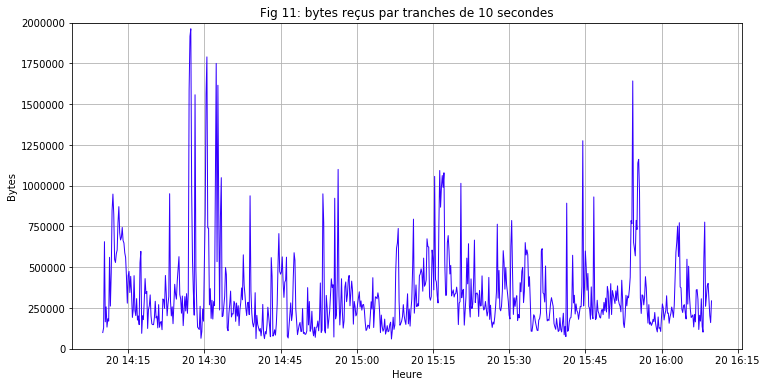

In [29]:
# traçage du graphique de la série temporelle
fig_11 = plt.figure(figsize=(12,6))
plt.plot(data['time'], data['bytes'], linewidth=1, c=(0.2, 0, 1));
plt.title('Fig 11: bytes reçus par tranches de 10 secondes')
plt.xlabel('Heure')
plt.ylabel('Bytes')
plt.ylim(0, 2000000)
plt.grid(True)
plt.show()

9. Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage
du modèle ne demande pas beaucoup de temps et s’effectue avec 1 - 2 ligne de code à l’aide
de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p
(d’une gamme de valeur prédéfinies, disons de 1 à pmax) est moins simple. On va aborder trois
possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation
croisée/backtesting.

    Les critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés
directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la
coupe en nchunks chunks/folds et chaque foi utilise k premiers chunks pour entrainer le modèle et
le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique) ; voir le dessin
ci-dessous.

Pour réaliser cet exercice, on va d'abord fixer un nombre de retards maximum pmax (par exemple 6). On évaluera ensuite un modèle pour chacun nombre de retards de 1 à pmax. A noter que comme les critères AIC et BIC ne sont pas des critères prédictifs (ils sont liés à la vraissemblance), ils ne nécessitent pas de couper l'échantillon en train/test. Pour la validation croisée en revanche on séparera bien l'échantillon en différentes train et tests, avec train un échantillon incrémental intégrant une fold supplémentaire à chaque fois. On pourra par exemple partir de 5 folds pour réaliser l'exercice.

In [30]:
# nombre maximum de retards
pmax = 6
# nombre de folds en validation croisée
nchunks = 5
# initialisation des critères
aic = np.zeros([pmax])
bic = np.zeros([pmax])
cv = np.zeros([pmax])
T = len(data['bytes'])

# boucle sur les retards
for p in range (1, pmax+1):
    # estimation du modèle AR(p) et récupération des critères
    AR_p = ARIMA(data['bytes'],order=(p,0,0))
    AR_p_estimates = AR_p.fit()
    aic[p-1] = AR_p_estimates.aic
    bic[p-1] = AR_p_estimates.bic
    # boucle sur les folds pour la validation croisée
    risks = np.zeros([nchunks-1])
    for k in range (1, nchunks):
        # échantillons train et test
        data_train = data['bytes'].loc[:(k/nchunks)*T-1]
        data_test = data['bytes'].loc[(k/nchunks)*T:((k+1)/nchunks)*T-1]
        # estimation du modèle AR(p)
        AR_p = ARIMA(data_train,order=(p,0,0))
        AR_p_estimates = AR_p.fit()
        # predictions
        pred = AR_p_estimates.predict(start=int((k/nchunks)*T), end=int(((k+1)/nchunks)*T-1))
        # risque quadratique prédictif
        resids = data_test - pred
        risk = np.sum(resids ** 2) / len(data_test)
        risks[k - 1] = risk
    cv[p-1] = np.sum(risks) / len(risks)
    
# obtention du meilleur modèle selon critère
p_aic = np.argmin(aic) + 1
print("AIC choisit " + str(p_aic) + " retards.")
p_bic = np.argmin(bic) + 1
print("BIC choisit " + str(p_bic) + " retards.")
p_cv = np.argmin(cv) + 1
print("La validation croisée choisit " + str(p_cv) + " retards.")

AIC choisit 2 retards.
BIC choisit 1 retards.
La validation croisée choisit 2 retards.


10. En se basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à
estimer et affichez les paramètres correspondants. Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement.
Commentez.

Comme deux critères sur trois retiennent deux retards, on utilisera ce nombre là.

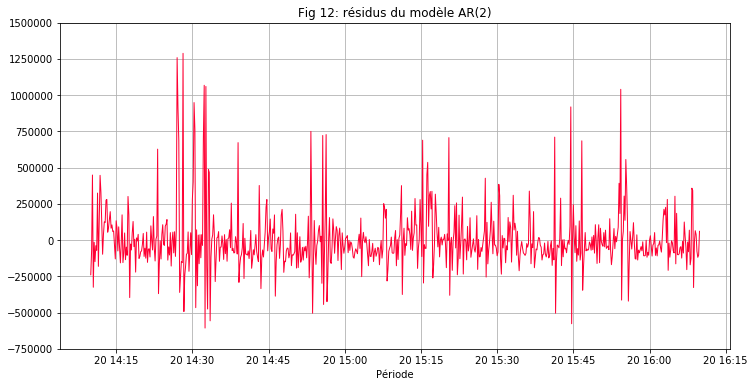

In [31]:
# estimation du modèle avec deux retards et résidus
AR_2 = ARIMA(data['bytes'],order=(2,0,0))
AR_2_estimates = AR_2.fit()
resids = AR_2_estimates.resid
# traçage des résidus
fig_12 = plt.figure(figsize=(12,6))
plt.plot(data['time'], resids, linewidth=1, c=(1, 0, 0.2));
plt.title("Fig 12: résidus du modèle AR(2)")
plt.xlabel('Période')
plt.ylim([-750000, 1500000])
plt.grid(True)
plt.show()

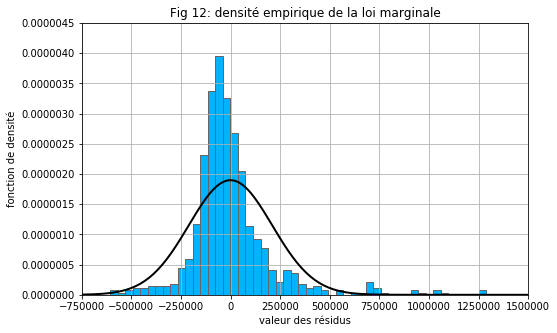

In [32]:
# on fait maintenant un fit de distribution normale sur les résidus
mu, std = norm.fit(resids)
x = np.linspace(-750000, 1500000, 200)
pdf = norm.pdf(x, mu, std)
# traçage de l'histogramme
fig12 = plt.figure(figsize=(8,5))
plt.hist(resids, bins = 50, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.plot(x, pdf, 'k', linewidth=2)
plt.xlabel('valeur des résidus')
plt.ylabel('fonction de densité')
plt.title('Fig 12: densité empirique de la loi marginale')
plt.ylim(0, 0.0000045) 
plt.xlim(-750000,1500000)
plt.grid(True)
plt.show()

On observe que l'approximation des résidus par une loi normale n'est pas parfaite. La distribution empirique voit sa densité d'avantage resserrée autour de la moyenne que la loi normale qui lui correspond (phénomène de thin tail). Cet étalement est vraisemblablement dû aux valeurs positives extrêmes de la distribution qui tirent les queues de la distribution interpolée vers l'extérieur. Si l'on ignore ces valeurs extrêmes toutefois, la forme de la distribution empirique devient proche d'une loi normale centrée en zéro, et ne montre pas d'asymétrie évidente. Globalement, les résidus produits par ce modèle sont satisfaisants, excepté, encore une fois, quelques valeurs extrêmes.

# Données "Southern oscillation index"

11. Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/
soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

On commence par comprendre la série en regardant la documentation:
    
"The Southern Oscillation Index, or SOI, gives an indication of the development and intensity of El Niño or La Niña events in the Pacific Ocean. The SOI is calculated using the pressure differences between Tahiti and Darwin.

Sustained negative values of the SOI below −7 often indicate El Niño episodes. These negative values are usually accompanied by sustained warming of the central and eastern tropical Pacific Ocean, a decrease in the strength of the Pacific Trade Winds, and a reduction in winter and spring rainfall over much of eastern Australia and the Top End. You can read more about historical El Niño events and their effect on Australia in the Detailed analysis of past El Niño events.

Sustainted positive values of the SOI above +7 are typical of a La Niña episode. They are associated with stronger Pacific trade winds and warmer sea temperatures to the north of Australia. Waters in the central and eastern tropical Pacific Ocean become cooler during this time. Together these give an increased probability that eastern and northern Australia will be wetter than normal. You can read more about historical La Niña events and their effect on Australia in the Detailed analysis of past La Niña events.

The ENSO Wrap-Up includes the latest 30-day SOI value, as well as other information on indicators of El Niño and La Niña events."

La série contient donc 30 jours d'information. On n'a cependant pas de détails sur la fréquence exacte des données ni sur les dates impliquées. Pour cette raison, on se contentera de définir les périodes comme 1, 2, ...

In [33]:
# import de la série
data = pd.read_csv("soi.tsv", delimiter="\t", header = None).T.rename(columns={0: "SOI"})
# comptage du nombre de valeurs manquantes et suppression
missing_values = data['SOI'].isnull().sum()
print("Il y a " + str(missing_values) + " données manquantes dans la série SOI.")
data = data.dropna()
data.tail()
#affichage des premières valeurs
data.head()

Il y a 1 données manquantes dans la série SOI.


,SOI
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


12. A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots,
tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

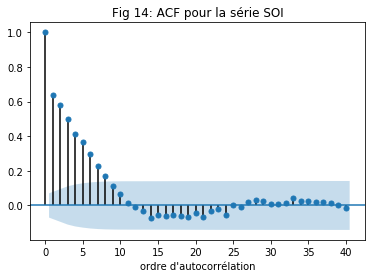

In [34]:
# traçage des ACF
plot_acf(data['SOI'], lags=40)
plt.title('Fig 14: ACF pour la série SOI')
plt.xlabel("ordre d'autocorrélation")
plt.show()

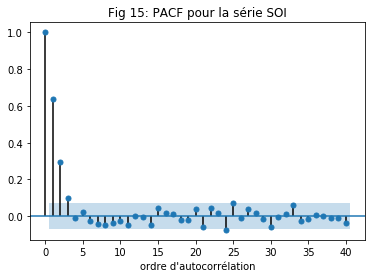

In [35]:
# traçage des PACF
plot_pacf(data['SOI'], lags=40)
plt.title('Fig 15: PACF pour la série SOI')
plt.xlabel("ordre d'autocorrélation")
plt.show()

13. En se basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p).
Entrainer le modèle AR choisi. Tracez les résidus. Tracez l’estimation de la densité de résidus et la
densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et
comparez les visuellement. Commentez.

On commence par examiner les ACF et les PACF de la question précédente. On observe que les ACF produisent des valeurs qui convergent graduellement vers 0, sans chute brutale des valeurs. Ce motif est typique des modèles AR(p) ou ARMA(p,q). Pour trancher entre AR et ARMA, il faut regarder les PACF. On observe que ces derniers n'ont que 3 valeurs significatives (on omet le "retard 0" dont la valeur est bien entendu de 1), puis chutent brutalement pour atteindre des valeurs virtuellement à 0. Ce motif est typique des processus AR (et non ARMA qui montreraient des oscillations périodiques des PACF). Comme il y a trois retards significatifs dans les PACF, on déduit qu'on a ici un processus AR(3).

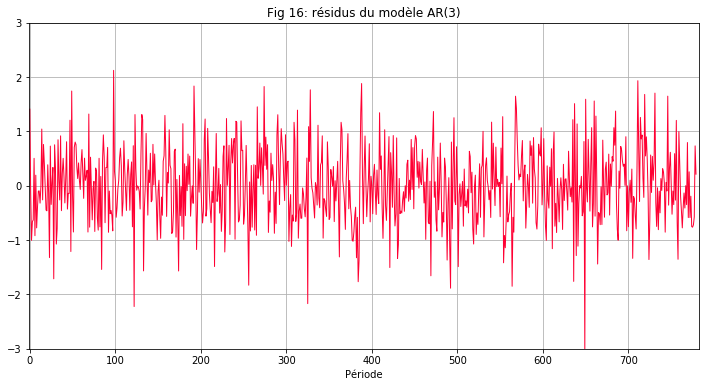

In [36]:
# création et entraînement du modèle
AR_3 = ARIMA(data['SOI'],order=(3,0,0))
AR_3_estimates = AR_3.fit()
resids = AR_3_estimates.resid
# traçage des résidus
fig_16 = plt.figure(figsize=(12,6))
plt.plot(resids, linewidth=1, c=(1, 0, 0.2));
plt.title("Fig 16: résidus du modèle AR(3)")
plt.xlabel('Période')
plt.xlim([-1, 782])
plt.ylim([-3, 3])
plt.grid(True)
plt.show()

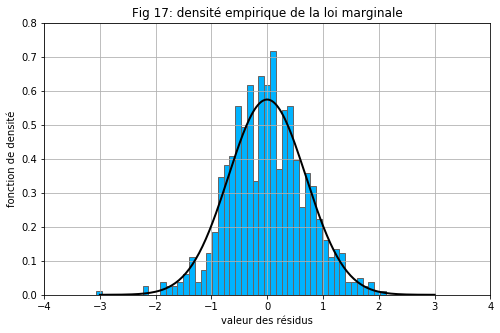

In [37]:
# on fait maintenant un fit de distribution normale sur les résidus
mu, std = norm.fit(resids)
x = np.linspace(-3, 3, 200)
pdf = norm.pdf(x, mu, std)
# traçage de l'histogramme
fig17 = plt.figure(figsize=(8,5))
plt.hist(resids, bins = 50, density = True, color = (0, 0.7, 1), edgecolor=(0.4, 0.4, 0.4))
plt.plot(x, pdf, 'k', linewidth=2)
plt.xlabel('valeur des résidus')
plt.ylabel('fonction de densité')
plt.title('Fig 17: densité empirique de la loi marginale')
plt.ylim(0, 0.8) 
plt.xlim(-4,4)
plt.grid(True)
plt.show()

On observe un très bon comportement des résidus. On peut d'abord voir sur la Figure 16 qu'ils ont l'air centrés en 0, et ne montrent aucun signe évident d'autocorrélation ou d'hétéroscedasticité. Comme le montre la Figure 17, ils produisent aussi une distribution symmétrique et à la forme de cloche caractéristique d'une distribution normale. La forme de leur histogramme colle en fait très bien à celle de la distribution normale qui lui correspond. On peut en conclure que notre modèle AR(3) est satisfaisant.

14. Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question
précédente.

In [38]:
# calcul de la densité spectrale du modèle estimé
# on recouvre les coefficients
coeffs = AR_3_estimates.arparams
# on estime sigma^2
sigma_2 = np.var(resids)
# création des fréquences omega considérées pour le traçage
omegas = np.linspace(-0.5, 0.5, 1000)
# initialisation des valeurs de densité spectrales
f_omega = np.zeros([len(omegas)])
# calcul de la densité spectrale
for index, omega in enumerate(omegas):
    acc = 0 + 0j
    # print(omega)
    for i in range(3):
        acc = acc + coeffs[i] * exp(-2*pi*(i+1)*omega*1j)
    f_omega[index] = sigma_2 * np.absolute(1 - acc) ** (-2)

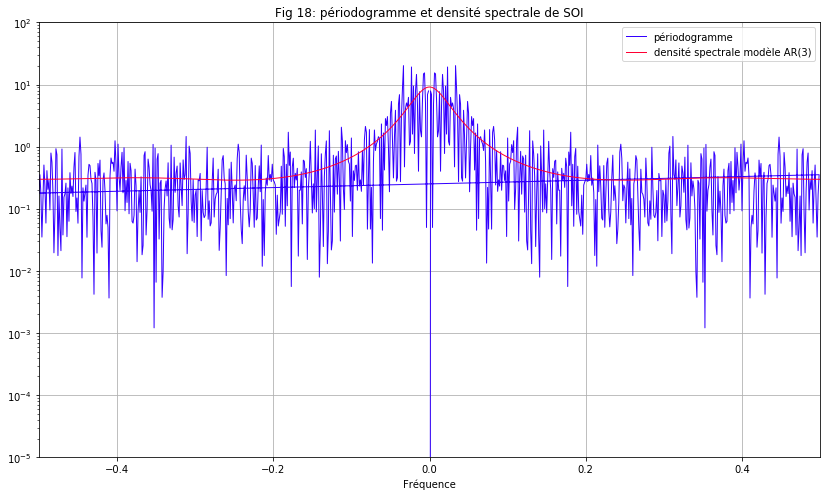

In [39]:
# estimation du périodogramme
f, Pxx = signal.periodogram(data['SOI'], return_onesided = False)
# traçage du périodogramme
fig18 = plt.figure(figsize=(14,8))
plt.semilogy(f, Pxx, linewidth=1, c=(0.2, 0, 1), label="périodogramme")
plt.title('Fig 18: périodogramme et densité spectrale de SOI')
plt.xlabel('Fréquence')
plt.grid(True)
plt.xlim([-0.5, 0.5])
plt.ylim([1e-05, 100])
# traçage de la densité spectrale
plt.plot(omegas, f_omega, linewidth=1, c=(1, 0, 0.2), label="densité spectrale modèle AR(3)")
plt.legend()
plt.show()

On observe que la densité spectrale du modèle AR(3) colle très bien au périodogramme. Notre modèle AR(3) rend donc bien compte des fréquences effectivement présentes dans la série de données. On en conclut que notre modèle AR(3) est un bon modèle.